In [28]:
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.figure import Figure


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error
)
from xgboost import XGBRegressor

pd.options.display.max_columns = None

from scripts.data_processing import (
    load_uci, load_tidepool_dummy, 
    load_so_pump, 
    load_so_cgm
)

In [7]:
def split_train_validate(df, minutes=30, test_fraction=0.2):
    test_size = int(df.shape[0] * test_fraction)
    df_train = df.iloc[0:-test_size]
    df_val   = df.iloc[-test_size:]
    print(f'train size: {len(df_train)}')
    print(f'test size: {len(df_val)}')
    
    target_name = str(minutes) + '_minutes'
    X_train  = df_train.drop(columns=[target_name])
    y_train  = df_train[target_name]
    
    X_val    = df_val.drop(columns=[target_name])
    y_val    = df_val[target_name]
    
    return X_train, X_val, y_train, y_val


def preprocess(df, minutes=30, n_historical_cols=2):
    # convert datetime to int
    df['timestamp'] = df['timestamp'].astype(np.int64) // 10**9

    for x in range(1, n_historical_cols+1):
        df[['prev_meas', 'prev_time']] = df[['measurement', 'timestamp']].shift(x)
        df[f'prev_trend_{x}'] = (
            df['prev_meas'].divide(df['timestamp'] - df['prev_time']))
        df = df.drop(columns=['prev_meas', 'prev_time'])

    # get 30 minute future value
    df = append_future_value_col(df, minutes)

    # remove nans
    og_len = len(df)
    df = df.loc[~df[f'{minutes}_minutes'].isna() & 
                ~df[f'prev_trend_{n_historical_cols}'].isna()]
    n_dropped = og_len - len(df)
    assert n_dropped < (10 + n_historical_cols)

    return df


def append_future_value_col(df, minutes):
    seconds = minutes * 60
    
    df[f'{minutes}_minutes'] = np.interp(
        df['timestamp'].add(seconds), df['timestamp'],
        df['measurement']
    )
    
    max_valid_time = df['timestamp'].max() - seconds
    df.loc[df['timestamp'] > max_valid_time, f'{minutes}_minutes'] = np.nan

    return df

### Compute baseline MSE

In [8]:
def baseline_rmse(df, minutes=30):
    # if we predict the same value as the current value
    df = preprocess(df, minutes)
    
    mse = sum((df[f'{minutes}_minutes'] - 
               df['measurement']).pow(2)) / len(df)
    
    return np.sqrt(mse)


baseline_rmse(df=load_so_cgm(), minutes=30)

24.176857912755537

### Build Model

In [9]:
df = load_so_cgm()
df = preprocess(df)

train size: 73638
test size: 18409


In [ ]:
df.head()

In [ ]:
# XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, importance_type='gain',
#        learning_rate=0.06, max_delta_step=0, max_depth=2,
#        min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
#        nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
#        reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
#        subsample=1)
# gave us +/- 18.66 mg/dL

In [14]:
def build_model(df, minutes=30):
    
    df = preprocess(df, minutes)
    
    X_train, X_val, y_train, y_val = \
                split_train_validate( \
                    df.copy(), minutes=minutes)
    
    param_grid = {  
        'learning_rate': [0.05, 0.06, 0.07, 0.08],
        'n_estimators':  [40, 50, 60],
        'max_depth': [2],
    #     'subsample': [0.5, 0.75, 0.9],
    #     'colsample_bytree': [0.1, 0.2, 0.3, 0.4],
    #     'gamma': [0, 1, 2]
    }

    gridsearch = GridSearchCV(XGBRegressor(),
                              param_grid=param_grid, 
                              # scoring='roc_auc', 
                              cv=3, n_jobs=-1,
                              return_train_score=True, verbose=10)
    gridsearch.fit(X_train, y_train)
    print('best estimator:', gridsearch.best_estimator_)
    print(gridsearch.cv_results_['mean_train_score'].mean(),
          gridsearch.cv_results_['mean_test_score'].mean())
    y_pred = gridsearch.predict(X_val)
    print('mae:', mean_absolute_error(y_val, y_pred))
    print('rmse:', np.sqrt(mean_squared_error(y_val, y_pred)))
    return gridsearch

In [18]:
df = load_so_cgm()
models = []
for minutes in range(5, 31, 5):
    with open('diabetesmanager/model_' + str(minutes) + '_minutes.pkl', 'wb') as f:
        model = build_model(df.copy(), minutes)
        models.append(model)
        pickle.dump(model, f)

train size: 73642
test size: 18410
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:    4.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    4.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:    5.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.6s finished
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
0.9489598515052449 0.9478224511167325
mae: 4.22761340755219
rmse: 6.140270865402551
train size: 73641
test size: 18410
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:    4.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    4.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:    5.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.7s finished
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
0.9221721841481129 0.9205550940514463
mae: 7.458788280880056
rmse: 10.60937788965531
train size: 73640
test size: 18410
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:    4.5s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    4.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:    5.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.6s finished
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
0.8855178236449032 0.8829619856641079
mae: 10.479823463735586
rmse: 14.691354738449414
train size: 73640
test size: 18409
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:    4.5s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    4.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:    5.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.7s finished
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
0.8412502304434638 0.8379157424558651
mae: 13.256854739028268
rmse: 18.394962522488143
train size: 73639
test size: 18409
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:    4.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    4.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:    5.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.7s finished
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
0.7908566763999851 0.7864303300804188
mae: 15.88488122693306
rmse: 21.816356729519534
train size: 73638
test size: 18409
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:    4.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    4.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:    5.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.8s finished
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
0.738171058853458 0.7325217686555159
mae: 18.251799651408216
rmse: 24.853446767565373


In [21]:
X_val.head()

,timestamp,measurement,below_threshold,prev_trend_1,prev_trend_2
6796,1549481226,162,False,0.540000,0.270000
6797,1549481525,156,False,0.541806,0.270451
6798,1549481825,149,False,0.520000,0.270451
6799,1549482126,145,False,0.495017,0.259567
6800,1549482426,142,False,0.483333,0.247920


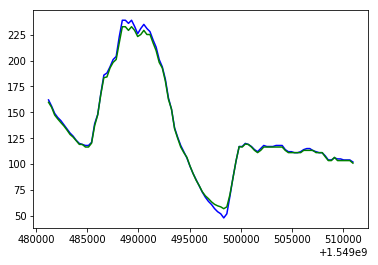

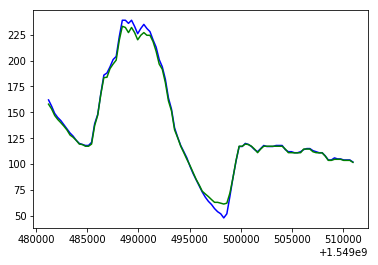

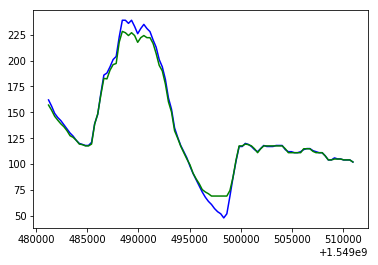

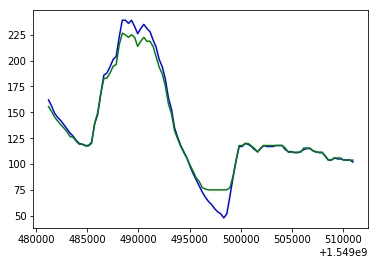

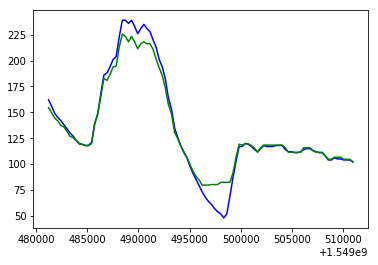

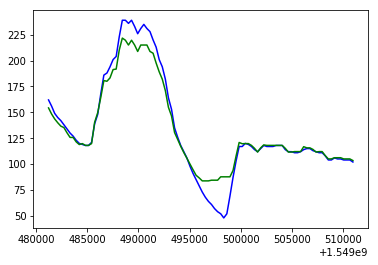

In [51]:
num_values = 100
for model in models:
    y_pred = model.predict(X_val.iloc[:num_values, :])
    fig = Figure()
    plt.plot(X_val.iloc[:num_values, 0], 
             X_val.iloc[:num_values, 1], color='b')
    plt.plot(X_val.iloc[:num_values, 0], y_pred, color='g')
    plt.show()

In [43]:
X_val.iloc[:10, 0]

6796    1549481226
6797    1549481525
6798    1549481825
6799    1549482126
6800    1549482426
6801    1549482726
6802    1549483026
6803    1549483325
6804    1549483626
6805    1549483925
Name: timestamp, dtype: int64

In [ ]:
def make_prediction(model, minutes=30):
    # pull in user data
    df = load_so_cgm()
    # process
    df = preprocess(df)
    df = df.drop(columns=[f'{minutes}_minutes'])
    # predict
    predictions = model.predict(df)
    
    df = df[['timestamp']].assign(predicted_value = list(predictions))
    df['timestamp'] = df['timestamp'] + 60 * minutes
    
    # TODO: make JSON or write to DB
    return df

In [ ]:
make_prediction(gridsearch)

### Write out model

In [ ]:
with open('diabetesmanager/model.pkl', 'wb') as f:
    pickle.dump(gridsearch, f)

### Load model

In [ ]:
with open('diabetesmanager/model.pkl', 'rb') as f:
    gridsearch = pickle.load(f)